#TensorFlow Tutorial

본 문서는 TensorFlow 를 사용하여 Deep Learning을 구현하기 위한 기초적인 실습 자료이다. 첫 번째 파트에서는 tensorflow에 대한 기본적인 설명과 deep learning 예제를 다루어보고, 두 번째 파트에서는 오픈소스를 활용한 Deep Reinforcement Learning 을 실습해보는 시간을 갖는다. 마지막으로 세 번째 파트에서는 주어진 데이터를 가장 잘 fitting 할 수 있는 regression 모델을 직접 작성해본다.

The code and comments are written by Dong-Hyun Kwak (imcomking@gmail.com)

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.


## Part 1. TensorFlow

TensorFlow 이하, tf는 구글 주도하에 초기 개발되고, 현재 오픈소스로 공개되어 널리 쓰이고 있는 분산 기계학습(딥러닝)을 위한 라이브러리이다. Computation Graph를 사용한 Theano의 장점을 그대로 살려 automatic gradient 계산이 가능하고, Spark처럼 분산 클라우드 컴퓨팅 환경에서 동작하기 위한 아키텍처로 설계되었다. 그리고 당연히 GPU와 CPU 연산 모두 지원한다.

Computation Graph는 tf를 이해하는 데 가장 중요한 핵심이다. 말그대로 어떤 모델을 우리가 코딩하게 되면, 이 모델의 계산 과정이 일련의 node와 edge들로 연결된 graph를 이루게 되는데 이것이 바로 Computation Graph이다.

그래서 성공적으로 모델을 작성하게 되면 아래와 같은 Computation Graph(MLP의 feedforward 연산과정)가 만들어 진다.

<img src = "tensorboard_mlp.png">

우선 기본적인 tf의 문법과 형식을 익히기 위해, 가장 기본적인 Deep Learning인 MLP 예제 코드를 실습해보자.

### Multi-Layer Perceptron
Multi-Layer Perceptron, 이하 MLP는 다음과 같은 구조를 가진 모델이다. Convolutional Neural Networks와 달리 굉장히 layer간의 연결이 빽빽하게 가득 차 있어, dense layer 혹은 fully connected layer라는 이름으로도 불리고 있다.



<img src = "mlp.png">
(출처: http://blog.refu.co/?p=931)

tf를 이용해서 MNIST 데이터를 MLP로 분류하는 코드를 작성해보자.
가장 먼저 사용할 라이브러리를 import 해준다.

In [7]:
%matplotlib inline
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
print (tf.__version__)

0.8.0


그리고 실습에서 사용할 MNIST 데이터를 다음과 같이 다운로드 받는다.

In [2]:
# download the mnist data.
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


이제 mnist 데이터를 저장시킬 x와 y_target 변수를 선언해야한다.
tf.placeholder는 우리가 원하는 데이터를 Computation Graph에 입력시켜주는 역할을 하는 변수이다. 즉 input 을 받기 위한 변수라고 생각할 수 있다.

In [3]:
# placeholder is used for feeding data.
x = tf.placeholder("float", shape=[None, 784]) # none represents variable length of dimension. 784 is the dimension of MNIST data.
y_target = tf.placeholder("float", shape=[None, 10]) # shape argument is optional, but this is useful to debug.

데이터를 넣을 변수를 생성했으니, 이제 실제 Neural Network에서 사용할 변수들을 생성하고, 이들을 이용해 Computation Graph를 그려본다.

In [4]:
# all the variables are allocated in GPU memory
W1 = tf.Variable(tf.zeros([784, 256]))      # create (784 * 256) matrix
b1 = tf.Variable(tf.zeros([256]))           # create (1 * 256) vector
weighted_summation1 = tf.matmul(x, W1) + b1 # compute --> weighted summation
h1 = tf.sigmoid( weighted_summation1 )      # compute --> sigmoid(weighted summation)

# Repeat again
W2 = tf.Variable(tf.zeros([256, 10]))        # create (256 * 10) matrix
b2 = tf.Variable(tf.zeros([10]))             # create (1 * 10) vector
weighted_summation2 = tf.matmul(h1, W2) + b2 # compute --> weighted summation
y = tf.nn.softmax(weighted_summation2)       # compute classification --> softmax(weighted summation)

위의 과정까지 완료된 경우, 변수 y는 3층짜리 Neural Network(MLP)의 연산 결과가 저장되도록 되어있다. 이제 이 MLP를 학습하고 실행시켜보자.

먼저 tf에는 Session이라는 개념이 있다. 이는 간단히 말해 하나의 Computation Graph가 실행되기 위한 계산 단위를 의미한다. 즉 하나의 session에는 보통 하나의 graph가 담겨있다. 이를 생성해보자.

In [5]:
#with tf.Graph().as_default():
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True))) # open a session which is a envrionment of computation graph.
sess.run(tf.initialize_all_variables())# initialize the variables

위의 tf.initialize_all_variables() 는 앞서 생성했던 변수들을 사용하기 위해서 반드시 실행해야하는 초기화 단계이다. 이 연산은 session에 의해서 실행되므로, 이와 같이 sess.run() 함수를 이용해 실행시켜준다.

이제 MLP를 학습시키기 위한 미분 계산과 같은 수학적인 연산들을 정의해보자.

In [6]:
# define the Loss function
cross_entropy = -tf.reduce_sum(y_target*tf.log(y))

cross entorpy는 MLP의 분류 모델에서 사용하는 에러함수이다. 간단히 말해 이 cross entropy는 MLP가 예측한 y 값이 실제 데이터와 다른 정도를 확률적으로 측정한다고 생각해볼 수 있다.

MLP가 학습 되기위해서는 이 에러함수가 최대한 작은 값을 내도록 만들어야한다. 그래서 이 에러함수를 각각의 변수들로 편미분하여 gradient를 계산하고, 에러가 최소가 되는 변수값을 찾아가는 것이 바로 MLP의 학습 알고리즘이다.

이를 구현하려면 원래 미분 후 에러가 줄어드는 방향으로 변수를 이동시키는 과정등을 직접 코딩해야하지만, 자동 미분을 제공하는 tf에서는 단 한줄로 구현할 수 있다.


In [7]:
# define optimization algorithm
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

이제 학습 알고리즘의 구현이 끝났고, MLP가 잘 학습하고 있는지 성능을 측정하기 위한 정확도 계산을 정의해보자.

In [8]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_target, 1))
# correct_prediction is list of boolean which is the result of comparing(model prediction , data)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) 
# tf.cast() : changes true -> 1 / false -> 0
# tf.reduce_mean() : calculate the mean

correct_prediction 는 뭔가 수식이 복잡해 보이지만 사실 매우 간단한 계산이다. tf.argmax()는 y 벡터 중에서 가장 값이 큰 index를 알려주는 함수이다. 즉 모델이 예측한 class, y와 실제 데이터에 labeling된 y_target을 비교하여 같으면 true, 다르면 false를 내도록 계산한 것이다.

그리고 accuracy는 앞서 계산한 true/false 리스트를 1과 0으로 변환한 뒤, 이를 평균낸 것이다.

자 그러면 이제 필요한 모든 Computation Graph를 정의하였다. 이제 이를 session을 이용하여 실행만 시키면 된다.


우선은 Ctrl + Enter를 눌러 다음 코드를 실행 시켜보자.

In [9]:
# training the MLP
for i in range(5001): # minibatch iteraction
    batch = mnist.train.next_batch(100) # minibatch size
    sess.run(train_step, feed_dict={x: batch[0], y_target: batch[1]}) # feed data into placeholder x, y_target

    if i%500 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={x:batch[0], y_target: batch[1]})
        print "step %d, training accuracy: %.3f"%(i, train_accuracy)

# for given x, y_target data set
print  "test accuracy: %g"% sess.run(accuracy, feed_dict={x: mnist.test.images, y_target: mnist.test.labels})
sess.close()
tf.reset_default_graph()

step 0, training accuracy: 0.120
step 500, training accuracy: 0.530
step 1000, training accuracy: 0.780
step 1500, training accuracy: 0.910
step 2000, training accuracy: 0.910
step 2500, training accuracy: 0.950
step 3000, training accuracy: 0.890
step 3500, training accuracy: 0.940
step 4000, training accuracy: 0.930
step 4500, training accuracy: 0.970
step 5000, training accuracy: 0.950
test accuracy: 0.9312


총 5000번의 minibatch iteraction을 실행하고, 500번 마다 학습 정확도를 측정, 그리고 마지막에는 테스트 정확도를 측정하고 있다.

코드는 간단한 구조이다. for 문이 전체 iteration을 실행하고, 맨 처음 가져왔던 mnist 데이터를 100개씩 가져와서 place_holder에 넣어준다. 그리고 sess.run()을 통해 위에서 정의했던 학습 알고리즘과 정확도 계산을 실행시킨다.

이제 우리가 만든 MLP의 구조를 직접 눈으로 확인해보자.

### TensorBoard 설정하기
TensorFlow는 TensorBoard라는 매우 강력한 visualization tool을 제공한다. 이를 사용하면 웹브라우저 형태로 사용자가 모델의 구조를 눈으로 확인하고, 파라미터 값의 변화를 살펴보는 등의 직관적인 분석이 가능하다.

이를 활용해 방금 만들었던 MLP를 분석해보자. 그러려면 다음의 사항을 반영해 코드를 수정하여야 한다.

* **변수들의 이름 지어주기**

* **변수들의 Summary 생성**

* **변수들의 Summary 기록**

아래의 코드는 위의 3가지 사항을 모두 반영하고, MLP 코드를 하나의 함수로 정리한 코드이다. 세세한 차이는 위에서 우리가 짰던 코드와 비교를 하면 파악이 가능하다.

In [10]:
%matplotlib inline
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

tf.reset_default_graph()

def MLP():
    # download the mnist data.
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True) 


    # placeholder is used for feeding data.
    x = tf.placeholder("float", shape=[None, 784], name = 'x') # none represents variable length of dimension. 784 is the dimension of MNIST data.
    y_target = tf.placeholder("float", shape=[None, 10], name = 'y_target') # shape argument is optional, but this is useful to debug.


    # all the variables are allocated in GPU memory
    W1 = tf.Variable(tf.zeros([784, 256]), name = 'W1')   # create (784 * 256) matrix
    b1 = tf.Variable(tf.zeros([256]), name = 'b1')        # create (1 * 256) vector
    h1 = tf.sigmoid(tf.matmul(x, W1) + b1, name = 'h1')   # compute --> sigmoid(weighted summation)

    # Repeat again
    W2 = tf.Variable(tf.zeros([256, 10]), name = 'W2')     # create (256 * 10) matrix
    b2 = tf.Variable(tf.zeros([10]), name = 'b2')          # create (1 * 10) vector
    y = tf.nn.softmax(tf.matmul(h1, W2) + b2, name = 'y')  # compute classification --> softmax(weighted summation)


    # define the Loss function
    cross_entropy = -tf.reduce_sum(y_target*tf.log(y), name = 'cross_entropy')


    # define optimization algorithm
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)



    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_target, 1))
    # correct_prediction is list of boolean which is the result of comparing(model prediction , data)


    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) 
    # tf.cast() : changes true -> 1 / false -> 0
    # tf.reduce_mean() : calculate the mean



    # create summary of parameters
    tf.histogram_summary('weights_1', W1)
    tf.histogram_summary('weights_2', W2)
    tf.histogram_summary('y', y)
    tf.scalar_summary('cross_entropy', cross_entropy)
    merged = tf.merge_all_summaries()
    summary_writer = tf.train.SummaryWriter("/tmp/mlp")


    # Create Session
    sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))) # open a session which is a envrionment of computation graph.
    sess.run(tf.initialize_all_variables())# initialize the variables

    # training the MLP
    for i in range(5001): # minibatch iteraction
        batch = mnist.train.next_batch(100) # minibatch size
        sess.run(train_step, feed_dict={x: batch[0], y_target: batch[1]}) # placeholder's none length is replaced by i:i+100 indexes

        if i%500 == 0:
            train_accuracy = sess.run(accuracy, feed_dict={x:batch[0], y_target: batch[1]})
            print "step %d, training accuracy: %.3f"%(i, train_accuracy)



            # calculate the summary and write.
            summary = sess.run(merged, feed_dict={x:batch[0], y_target: batch[1]})
            summary_writer.add_summary(summary , i)

    # for given x, y_target data set
    print  "test accuracy: %g"% sess.run(accuracy, feed_dict={x: mnist.test.images, y_target: mnist.test.labels})
    sess.close()

MLP()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, training accuracy: 0.120
step 500, training accuracy: 0.370
step 1000, training accuracy: 0.410
step 1500, training accuracy: 0.370
step 2000, training accuracy: 0.680
step 2500, training accuracy: 0.750
step 3000, training accuracy: 0.840
step 3500, training accuracy: 0.870
step 4000, training accuracy: 0.920
step 4500, training accuracy: 0.900
step 5000, training accuracy: 0.900
test accuracy: 0.9042


### TensorBoard 실행하기
위와 같이 코드를 수정했다면, 이제 리눅스 shell로 이동한 후, tensorboard를 실행시킨다.
혹은 IPython에서 new -> terminal을 클릭하여 아래의 명령을 실행할 수도 있다.


tensorboard --logdir=/tmp/mlp


(만약 위 명령어 실행시 문제가 생기는 경우 다음을 실행)
<br>cd tensorflow/tensorflow/tensorboard
<br>python tensorboard.py --logdir=/tmp/mlp


그다음 [docker_default_IP]:6006/#graphs 에 접속하면 아래와 같은 그림을 볼 수 있다.
<br>(ex) http://192.168.99.100:6006/#graphs


<img src = "mlp_total.png">

이번에는 이미지 인식 분야에서 가장 성공적으로 쓰이고 있는 Convolutional Neural Networks를 실습해본다.

### Convolutional Neural Networks
Convolutional Neural Networks, 이하 CNN은 아래와 같은 Convolutional Layer를 여러층 가진 딥러닝 모델을 뜻한다.




<img src = http://ufldl.stanford.edu/tutorial/images/Cnn_layer.png>
(출처: http://ufldl.stanford.edu/tutorial/images/Cnn_layer.png)

최근에는 아래와 같이 매우 깊은 층으로 Convolutional Layer를 쌓아 매우 방대한 량의 이미지를 학습하는 경우가 많다.

<img src = https://qph.is.quoracdn.net/main-qimg-cf89aa517e5b641dc8e41e7a57bafc2c?convert_to_webp=true>
(출처: https://qph.is.quoracdn.net/main-qimg-cf89aa517e5b641dc8e41e7a57bafc2c?convert_to_webp=true)

이번에는 간단한 구조를 가진 CNN을 구현하고 방금전에 사용했던 MNIST 데이터를 학습시켜 보고, MLP와의 성능 차이를 비교해본다.

아래의 코드를 보면 MLP와 전체 구조는 매우 유사한데, 중간에 Convolutional을 비롯해 처음 보는 여러 연산들이 추가 된 것을 알 수 있다. 또한 CNN을 효과적으로 학습하기 위해서는 Weight의 초기화를 0으로 하는 것이 아니라, 랜덤으로 해주어야하는데, 여기서는 간단히 가우시안을 이용하여 초기화 하였다. 그밖에 dropout과 relu 등이 사용되었다.

각 함수와 연산들의 자세한 설명은 아래 코드를 보면서 하나하나 분석해보자.

In [4]:
%matplotlib inline
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
tf.reset_default_graph()

def CNN():
    # download the mnist data.
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True) 


    # placeholder is used for feeding data.
    x = tf.placeholder("float", shape=[None, 784], name = 'x') # none represents variable length of dimension. 784 is the dimension of MNIST data.
    y_target = tf.placeholder("float", shape=[None, 10], name = 'y_target') # shape argument is optional, but this is useful to debug.


    
    # reshape input data
    x_image = tf.reshape(x, [-1,28,28,1], name="x_image")
    
    # Build a convolutional layer and maxpooling with random initialization
    W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1), name="W_conv1") # W is [row, col, channel, feature]
    b_conv1 = tf.Variable(tf.zeros([32]), name="b_conv1")
    h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1, name="h_conv1")
    h_pool1 = tf.nn.max_pool( h_conv1 , ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name = "h_pool1")
    
    # Repeat again with 64 number of filters
    W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1), name="W_conv2") # W is [row, col, channel, feature]
    b_conv2 = tf.Variable(tf.zeros([64]), name="b_conv2")
    h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2, name="h_conv2")
    h_pool2 = tf.nn.max_pool( h_conv2 , ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name = "h_pool2")
    
    # Build a fully connected layer
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64], name="h_pool2_flat")
    W_fc1 = tf.Variable(tf.truncated_normal([7 * 7 * 64, 1024], stddev=0.1), name = 'W_fc1')
    b_fc1 = tf.Variable(tf.zeros([1024]), name = 'b_fc1')
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1, name="h_fc1")

    
    # Dropout Layer
    keep_prob = tf.placeholder("float", name="keep_prob")
    h_fc1 = tf.nn.dropout(h_fc1, keep_prob, name="h_fc1_drop")
    
    # Build a fully connected layer with softmax 
    W_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1), name = 'W_fc2')
    b_fc2 = tf.Variable(tf.zeros([10]), name = 'b_fc2')
    y=tf.nn.softmax(tf.matmul(h_fc1, W_fc2) + b_fc2, name="y")
    



    # define the Loss function
    cross_entropy = -tf.reduce_sum(y_target*tf.log(y), name = 'cross_entropy')
    

    # define optimization algorithm
    #train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)



    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_target, 1))
    # correct_prediction is list of boolean which is the result of comparing(model prediction , data)


    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) 
    # tf.cast() : changes true -> 1 / false -> 0
    # tf.reduce_mean() : calculate the mean



    # create summary of parameters
    tf.histogram_summary('weights_1', W_conv1)
    tf.histogram_summary('weights_2', W_conv2)
    tf.histogram_summary('y', y)
    tf.scalar_summary('cross_entropy', cross_entropy)
    merged = tf.merge_all_summaries()
    summary_writer = tf.train.SummaryWriter("/tmp/cnn")

    
    # Create Session
    sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))   # open a session which is a envrionment of computation graph.
    sess.run(tf.initialize_all_variables())# initialize the variables


    # training the MLP
    for i in range(5001): # minibatch iteraction
        batch = mnist.train.next_batch(100) # minibatch size
        sess.run(train_step, feed_dict={x: batch[0], y_target: batch[1], keep_prob: 0.5}) # placeholder's none length is replaced by i:i+100 indexes

        if i%500 == 0:
            train_accuracy = sess.run(accuracy, feed_dict={x:batch[0], y_target: batch[1], keep_prob: 1})
            print "step %d, training accuracy: %.3f"%(i, train_accuracy)

            # calculate the summary and write.
            summary = sess.run(merged, feed_dict={x:batch[0], y_target: batch[1], keep_prob: 1})
            summary_writer.add_summary(summary , i)

    # for given x, y_target data set
    print  "test accuracy: %g"% sess.run(accuracy, feed_dict={x: mnist.test.images[0:250], y_target: mnist.test.labels[0:250], keep_prob: 1})
    sess.close()
CNN()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, training accuracy: 0.070
step 500, training accuracy: 0.980
step 1000, training accuracy: 0.990
step 1500, training accuracy: 0.990
step 2000, training accuracy: 0.980
step 2500, training accuracy: 0.990
step 3000, training accuracy: 1.000
step 3500, training accuracy: 0.990
step 4000, training accuracy: 0.990
step 4500, training accuracy: 0.990
step 5000, training accuracy: 1.000
test accuracy: 0.996


학습 결과, MLP보다 훨씬 성능이 높아진 것을 알 수 있고 동시에 학습 속도가 MLP보다 느려진 것을 확인할 수 있다. 

이제 마찬가지로 TensorBoard를 통해서 우리가 만든 Computation Graph를 직접 눈으로 또 확인해보자.

<img src = "cnn.png">

지금까지 배운 MLP, CNN과 더불어 Deep Learning에서 쓰이는 가장 강력한 모델로 Recurrent Neural Networks를 빼놓을 수 없다. 마지막으로 이 알고리즘 또한 익혀보자.

### Recurrent Neural Networks
Recurrent Neural Networks, 이하 RNN는 다음과 같은 구조를 가진 모델이다. RNN은 자기자신을 향하는 weight를 이용해 데이터간의 시간관계를 학습할 수 있다. 이러한 문제들을 시계열 학습이라고 부르며, 기존에 널리 쓰이던 Hidden Markov Model을 뉴럴넷을 이용해 구현했다고 볼 수 있다.




<img src  = "https://raw.githubusercontent.com/peterroelants/peterroelants.github.io/master/notebooks/RNN_implementation/img/SimpleRNN01.png">
(출처: https://raw.githubusercontent.com/peterroelants/peterroelants.github.io/master/notebooks/RNN_implementation/img/SimpleRNN01.png)

위의 구조는 1개의 Recurrent weight를 가진 hidden node이다. 이러한 hidden node들이 여러개를 모여 1개의 RNN layer를 형성하고, 이것이 다시 deep 하게 쌓이는 모델 또한 가능하다.(그러나 RNN은 deep 하게 쌓을 경우 학습이 쉽지 않다.)

RNN의 경우 MLP나 CNN에 비해서 구현이 다소 복잡하다. 따라서 RNN은 skflow 라는 TensorFlow 공식 wrapping library를 활용해서 구현해보자.

https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/learn/python/learn

Skflow는 사용자가 최소한의 노력으로, 매우 추상화된 함수들을 사용해 deep learning 모델을 구축하고 학습할 수 있게 도와주는 역할을 한다.

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from sklearn import metrics
import pandas

import tensorflow as tf
from tensorflow.contrib import learn

### Training data
# Downloads, unpacks and reads DBpedia dataset.
dbpedia = learn.datasets.load_dataset('dbpedia')
X_train, y_train = pandas.DataFrame(dbpedia.train.data)[1], pandas.Series(dbpedia.train.target)
X_test, y_test = pandas.DataFrame(dbpedia.test.data)[1], pandas.Series(dbpedia.test.target)

### Process vocabulary
MAX_DOCUMENT_LENGTH = 10

vocab_processor = learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH)
X_train = np.array(list(vocab_processor.fit_transform(X_train)))
X_test = np.array(list(vocab_processor.transform(X_test)))

n_words = len(vocab_processor.vocabulary_)
print('Total words: %d' % n_words)

### Models
EMBEDDING_SIZE = 50

# Customized function to transform batched X into embeddings
def input_op_fn(X):
    # Convert indexes of words into embeddings.
    # This creates embeddings matrix of [n_words, EMBEDDING_SIZE] and then
    # maps word indexes of the sequence into [batch_size, sequence_length,
    # EMBEDDING_SIZE].
    word_vectors = learn.ops.categorical_variable(X, n_classes=n_words,
        embedding_size=EMBEDDING_SIZE, name='words')
    # Split into list of embedding per word, while removing doc length dim.
    # word_list results to be a list of tensors [batch_size, EMBEDDING_SIZE].
    word_list = learn.ops.split_squeeze(1, MAX_DOCUMENT_LENGTH, word_vectors)
    return word_list

# Single direction GRU with a single layer
classifier = learn.TensorFlowRNNClassifier(rnn_size=EMBEDDING_SIZE, 
    n_classes=15, cell_type='gru', input_op_fn=input_op_fn,
    num_layers=1, bidirectional=False, sequence_length=None,
    batch_size = 8, steps=1000, optimizer='Adam', learning_rate=0.01, continue_training=True)

#classifier.sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
classifier.sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.05)))


# train for 1000 steps & predict on test set.
classifier.fit(X_train, y_train, logdir='/tmp/tf_examples/word_rnn')
score = metrics.accuracy_score(y_test, classifier.predict(X_test))
print('Accuracy: {0:f}'.format(score))

classifier.sess.close()

## Part 2. Deep Reinforcement Learing

Deep Reinforcement Learning이란, 기존의 강화학습에서 Q function을 딥러닝으로 근사하는 모델을 의미한다. 대표적으로 구글 Deep Mind의 Atari와 최근에 화제가 된 AlphaGo 역시 이 Deep Reinforcement Learning 응용의 한가지이다.

이번 파트에서는 Deep Reinforcement Learning을 이용해서 간단한 2차원 게임을 플레이하고, reward로 부터 스스로 학습하는 Kaparthy의 오픈소스 예제를 실습해 본다.

<img alt="Deep RL" style="border-width:0" width="600" src="example.gif?raw=true" />


(출처: https://github.com/nivwusquorum/tensorflow-deepq)

### Reinforcement Learning

Reinforcement Learning, 이하 RL은 supervised learning과 달리 데이터에 대한 정확한 정답을 받지 않고, 내가 한 행동에 대한 reward feedback 만으로 학습을 수행하는 알고리즘이다. 이를 강화학습이라 부르며, 이것을 수행하는 가장 대표적인 알고리즘으로 Q-Learning 이 있다.

RL을 이해하는 것은 매우 많은 공부를 필요로 하기 때문에, 우선 2D게임을 예로 들어 아주 기본적인 개념만 살펴본다.

* **State**: 게임에서의 각 물체들의 위치, 속도, 벽과의 거리 등을 의미한다.
* **Action**: 게임을 플레이하는 주인공의 행동을 의미한다. 여기서는 4가지 방향에 대한 움직임이 이에 해당한다.
* **Reward**: 게임을 플레이하면서 받는 score. 여기서는 초록색을 먹으면 +1 , 빨간색을 먹으면 -1을 점수로 받는다.
* **Value**: 해당 action 또는 state가 미래에 얼마나 큰 reward를 가져올 지에 대한 예측값.
* **Policy**: 주인공이 현재의 게임 State에서 Reward를 최대한 얻기 위해 Action을 선택하는 전략. 한마디로 [게임을 플레이하는 방법]자체를 의미한다.


In [6]:
%matplotlib inline
import tensorflow as tf
tf.reset_default_graph()

from tf_rl.controller import DiscreteDeepQ, HumanController
from tf_rl.simulation import KarpathyGame
from tf_rl import simulate
from tf_rl.models import MLP

from __future__ import print_function

#### Environment Settings

이제 우리가 원하는 게임 환경을 설정하고, 적절한 reward와 object의 개수 및 observation 을 조절한다

In [7]:
current_settings = {
    'objects': [
        'friend',
        'enemy',
    ],
    'colors': {
        'hero':   'yellow',
        'friend': 'green',
        'enemy':  'red',
    },
    'object_reward': {
        'friend': 1,
        'enemy': -1,
    },
    "num_objects": {
        'friend' : 25,
        'enemy' :  25,
    },
    
    'hero_bounces_off_walls': False,
    'world_size': (700,500),
    'hero_initial_position': [400, 300],
    'hero_initial_speed':    [0,   0],
    "maximum_speed":         [50, 50],
    "object_radius": 10.0,
    "num_observation_lines" : 32, # the number of antennas
    "observation_line_length": 240., # the length of antennas
    "tolerable_distance_to_wall": 50, 
    "wall_distance_penalty":  -0.0, # if the hero is close to wall, that receives penalty
    "delta_v": 50 # speed value
}

# create the game simulator
g = KarpathyGame(current_settings)


#### Deep Learning Architecture

이제 Q function을 근사하기 위한 딥러닝 모델을 만들어보자. 이번 예제에서는 위에서 보았던 4층짜리 MLP를 사용한다.

In [8]:
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))

    

journalist = tf.train.SummaryWriter("/tmp/drl")

# Brain maps from observation to Q values for different actions.
# Here it is a done using a multi layer perceptron with 2 hidden layers
brain = MLP([g.observation_size,], [200, 200, g.num_actions],  [tf.tanh, tf.tanh, tf.identity])

#### Make an Agent

이제 Discrete Deep Q learning 알고리즘이 이 게임을 플레이하면서 학습을 하도록 agent로 설정을 한다.

In [9]:
# The optimizer to use. Here we use RMSProp as recommended by the publication
optimizer = tf.train.RMSPropOptimizer(learning_rate= 0.001, decay=0.9)

# DiscreteDeepQ object
current_controller = DiscreteDeepQ(g.observation_size, g.num_actions, brain, optimizer, session,
                                   discount_rate=0.99, exploration_period=5000, max_experience=10000, 
                                   store_every_nth=4, train_every_nth=4,
                                   summary_writer=journalist)

session.run(tf.initialize_all_variables())
session.run(current_controller.target_network_update)
#journalist.add_graph(session.graph_def)

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f3bc1e87710>> ignored


#### Play the Game

실제로 게임을 플레이하면서 강화학습을 하는 과정을 지켜본다.

In [10]:
FPS          = 30
ACTION_EVERY = 3
    
fast_mode = True
if fast_mode:
    WAIT, VISUALIZE_EVERY = False, 20
else:
    WAIT, VISUALIZE_EVERY = True, 1

    
try:
    with tf.device("/gpu:0"):
        simulate(simulation=g,
                 controller=current_controller,
                 fps=FPS,
                 visualize_every=VISUALIZE_EVERY,
                 action_every=ACTION_EVERY,
                 wait=WAIT,
                 disable_training=False,
                 simulation_resolution=0.001,
                 save_path=None)
except KeyboardInterrupt:
    print("Interrupted")
    

#session.close()

<tf_rl.utils.svg.Scene instance at 0x7f3b941680e0>

Interrupted


#### Applications
* Parameter 들을 바꾸어 enemy와 friend의 개수 차이가 최대한 많이 나도록 agent를 학습시켜본다.
* Boss object를 추가해본다.
* Deep RL에서의 tensorboard를 열어서 visualize를 해본다.

지금까지 기본적인 Deep Learning 알고리즘들과 기계학습의 한 종류인 강화학습에 대한 예제 코드를 실습해보았다. 이번에는 지금까지 배운 내용을 바탕으로 Polynomial Curve Fitting이라는 여러 기계학습 서적에서 가장 기초적으로 다루는 문제를 직접 구현해본다.

## Part 3. Polynomial Curve Fitting (Polynomial Regression) 구현
Polynomial curve fitting은 N차 다항함수를 이용해서 주어진 데이터를 잘 연결하는 커브(함수)를 찾는 문제를 말한다.

아래의 코드는 https://github.com/sjchoi86/Tensorflow-101 에서 공개한 Linear Regression 예제를 가져온 것이다. 이제 주어진 데이터를 가장 잘 학습할 수 있는 모델을 아래 코드를 수정하여 직접 구현해본다.

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Prepare for Linear Regression

# Parameters 
training_epochs = 2000
display_step    = 50


# Set TensorFlow Graph
X = tf.placeholder(tf.float32, name="input")
Y = tf.placeholder(tf.float32, name="output")
W = tf.Variable(np.random.randn(), name="weight")
b = tf.Variable(np.random.randn(), name="bias")

# Construct a Model
activation = tf.add(tf.mul(X, W), b)

# Define Error Measure and Optimizer
learning_rate   = 0.01
cost = tf.reduce_mean(tf.pow(activation-Y, 2))
# learning_rate   = 0.001
# cost = tf.sqrt(tf.reduce_sum(tf.pow(activation-Y, 2)))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost) #Gradient descent

"""
 tf.reduce_sum()
 tf.reduce_mean()
 _____

 tf.pow(Yhat, Y, 2)
 tf.nn.softmax_cross_entropy_with_logits(Yhat, Y)
 _____

 tf.train.GradientDescentOptimizer(0.05).minimize(cost)
 tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
"""

# Initializer
init = tf.initialize_all_variables()


(" Type of 'train_X' is ", <type 'numpy.ndarray'>)
 Shape of 'train_X' is (1, 20)
(" Type of 'train_Y' is ", <type 'numpy.ndarray'>)
 Shape of 'train_Y' is (1, 20)


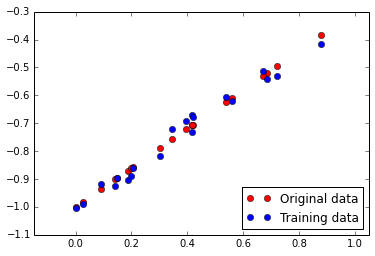

In [3]:
# Generate training data
np.random.seed(1)
def f(x, a, b):
    n    = train_X.size
    vals = np.zeros((1, n))
    for i in range(0, n):
        ax  = np.multiply(a, x.item(i))
        val = np.add(ax, b)
        vals[0, i] = val
    return vals

Wref = 0.7
bref = -1.
n    = 20
noise_var = 0.001
train_X   = np.random.random((1, n)) # 1 * 20 marix
ref_Y     = f(train_X, Wref, bref)
train_Y   = ref_Y + np.sqrt(noise_var)*np.random.randn(1, n)
n_samples = train_X.size # <= Just for using size operator 
print ("")
print (" Type of 'train_X' is ", type(train_X))
print (" Shape of 'train_X' is %s" % (train_X.shape,))
print (" Type of 'train_Y' is ", type(train_Y))
print (" Shape of 'train_Y' is %s" % (train_Y.shape,))

# Plot
plt.figure(1)
plt.plot(train_X[0, :], ref_Y[0, :], 'ro', label='Original data')
plt.plot(train_X[0, :], train_Y[0, :], 'bo', label='Training data')
plt.axis('equal')
plt.legend(loc='lower right')

In [4]:
# Run! 
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
# Initialize
sess.run(init)    
for epoch in range(training_epochs):
    for (x, y) in zip(train_X[0, :], train_Y[0, :]):
        # print "x: ", x, " y: ", y
        sess.run(optimizer, feed_dict={X:x, Y:y})
    
    # Check cost
    if epoch % display_step == 0:
        costval = sess.run(cost, feed_dict={X: train_X, Y:train_Y})
        print ("Epoch:", "%04d"%(epoch+1), "cost=", "{:.5f}".format(costval))
        Wtemp = sess.run(W)
        btemp = sess.run(b)
        print (" Wtemp is", "{:.4f}".format(Wtemp), "btemp is", "{:.4f}".format(btemp))
        print (" Wref is", "{:.4f}".format(Wref), "bref is", "{:.4f}".format(bref))
        
# Final W and b
Wopt = sess.run(W)
bopt = sess.run(b)
fopt = f(train_X, Wopt, bopt)

('Epoch:', '0001', 'cost=', '0.47523')
(' Wtemp is', '-0.5240', 'btemp is', '0.0690')
(' Wref is', '0.7000', 'bref is', '-1.0000')
('Epoch:', '0051', 'cost=', '0.01546')
(' Wtemp is', '0.1903', 'btemp is', '-0.8051')
(' Wref is', '0.7000', 'bref is', '-1.0000')
('Epoch:', '0101', 'cost=', '0.00245')
(' Wtemp is', '0.5134', 'btemp is', '-0.9314')
(' Wref is', '0.7000', 'bref is', '-1.0000')
('Epoch:', '0151', 'cost=', '0.00081')
(' Wtemp is', '0.6278', 'btemp is', '-0.9762')
(' Wref is', '0.7000', 'bref is', '-1.0000')
('Epoch:', '0201', 'cost=', '0.00060')
(' Wtemp is', '0.6683', 'btemp is', '-0.9920')
(' Wref is', '0.7000', 'bref is', '-1.0000')
('Epoch:', '0251', 'cost=', '0.00057')
(' Wtemp is', '0.6826', 'btemp is', '-0.9976')
(' Wref is', '0.7000', 'bref is', '-1.0000')
('Epoch:', '0301', 'cost=', '0.00057')
(' Wtemp is', '0.6877', 'btemp is', '-0.9996')
(' Wref is', '0.7000', 'bref is', '-1.0000')
('Epoch:', '0351', 'cost=', '0.00056')
(' Wtemp is', '0.6895', 'btemp is', '-1.0003

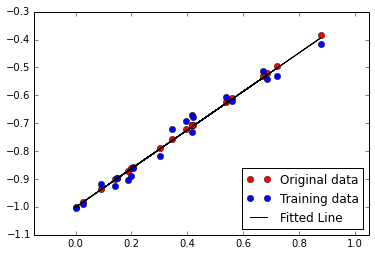

In [5]:
# Plot Results
plt.figure(2)
plt.plot(train_X[0, :], ref_Y[0, :], 'ro', label='Original data')
plt.plot(train_X[0, :], train_Y[0, :], 'bo', label='Training data')
plt.plot(train_X[0, :], fopt[0, :], 'k-', label='Fitted Line')
plt.axis('equal')
plt.legend(loc='lower right')

## * Open-source TensorFlow Implementation

아래 링크는 최신 연구들을 TensorFlow로 구현해놓은 오픈소스 프로젝트들을 모아서 정리해 둔 페이지이다. 이중 본인의 연구 분야와 관련있는 프로젝트를 clone, 수정하여 사용할 경우 개발시간을 크게 시간을 단축시킬 수 있다.


https://github.com/TensorFlowKR/awesome_tensorflow_implementations

유명한 오픈소스 몇가지 살펴보자.